In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, mean_squared_error, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split

## Parte I ##

# 2. Importar datos
hogares = pd.read_excel("C:/Users/tomas/Documents/UdeSA/Cuarto Año/Primer Cuatri/Big Data/TP4/usu_hogar_T423.xlsx")

hogares = hogares[hogares['AGLOMERADO'].isin([32, 33])]

individuos = pd.read_excel("C:/Users/tomas/Documents/UdeSA/Cuarto Año/Primer Cuatri/Big Data/TP4/usu_individual_T423.xlsx")

individuos = individuos[individuos['AGLOMERADO'].isin([32, 33])]


In [2]:
# Mergear base de individuos con la de los hogares

df = pd.merge(hogares, individuos, on=['CODUSU', 'NRO_HOGAR'], suffixes=('_x', '_y'))
columns_to_drop = [col for col in df if col.endswith('_y')]
df.drop(columns=columns_to_drop, inplace=True)
df.columns = [col.rstrip('_x') if col.endswith('_x') else col for col in df.columns]



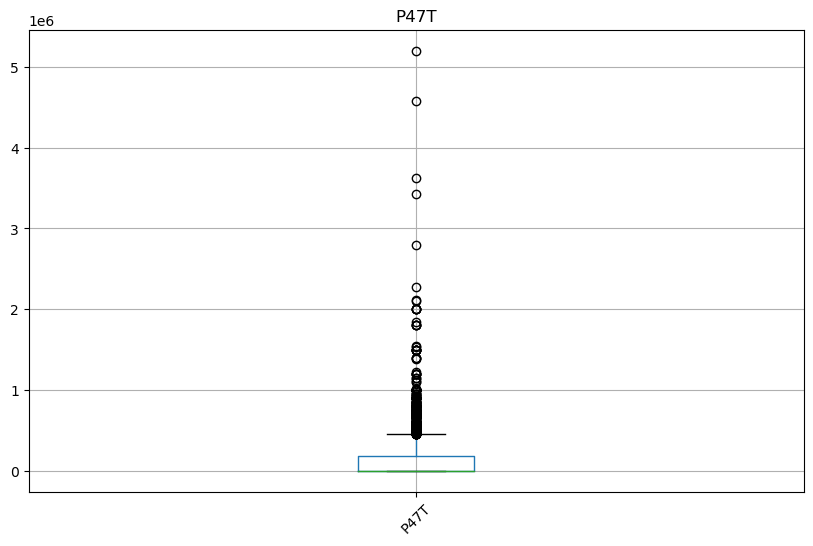

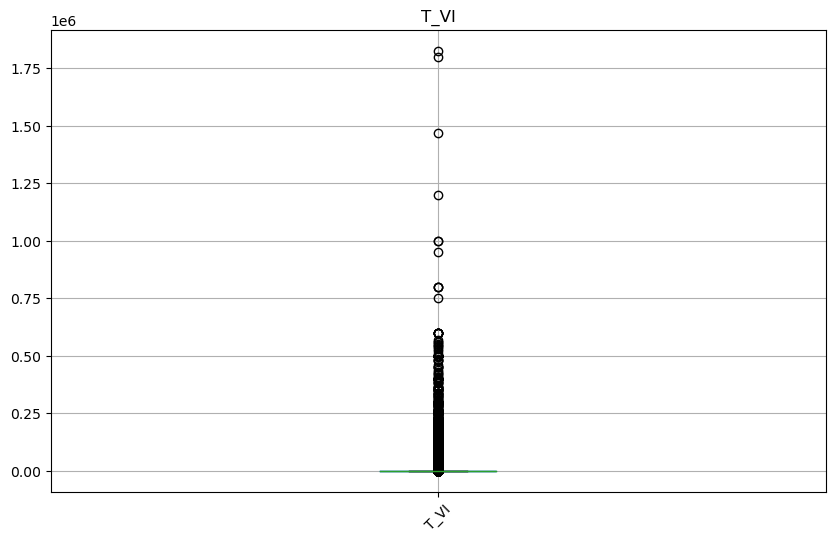

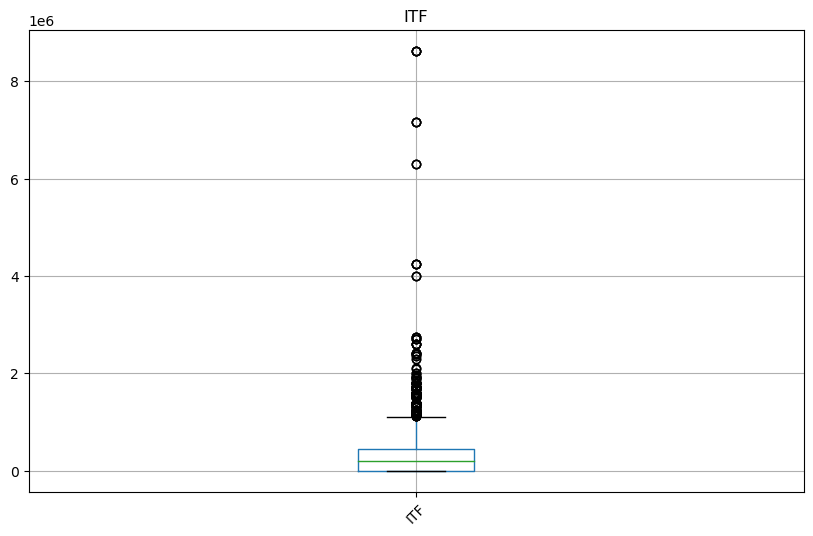

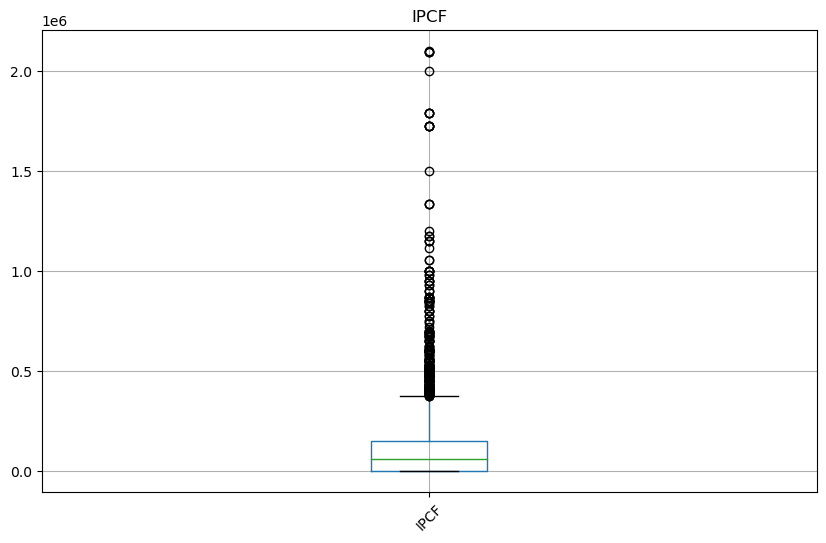

In [3]:
# 3. Limpiar base

#Variable categorica
df['MAS_500'] = np.where(df['MAS_500'] == 'S', 1, 0)

# Missing values: primero saque missings en p47T y luego elimine las columnas con missing
missing_values = df.isna().sum()
df = df.dropna(subset=['P47T'])
df = df.dropna(axis=1)

# Outliers o valores sin sentido

df = df[df['CH06'] > 0]

cols = ['P47T', 'T_VI' , 'ITF', 'IPCF']

for i in range(0, len(cols)):   
    plt.figure(figsize = (10, 6))
    df.boxplot(column = cols[i])
    plt.title(cols[i])
    plt.xticks(rotation = 45)
    plt.show()



In [4]:
# 4. Variables para predecir pobreza

#Propocion de niños en el hogar
casa = df.groupby('CODUSU')
total_personas = casa.size()
child = casa.apply(lambda x: (x['CH06'] < 18).sum())
proporcion_jovenes = child/total_personas
proporcion_jovenes = proporcion_jovenes.reset_index(name='proporcion_jovenes')
df = pd.merge(df, proporcion_jovenes, on='CODUSU')

#Proporcion de personas que trabajan
trabaja = casa.apply(lambda x: (x['ESTADO'] == 1).sum())
proporcion_trabaja = trabaja/total_personas
proporcion_trabaja = proporcion_trabaja.reset_index(name='proporcion_trabaja')
df = pd.merge(df, proporcion_trabaja, on='CODUSU')

#Proporcion de personas que saben leer y escribir
leer_escribir = casa.apply(lambda x: (x['CH09'] == 1).sum())
proporcion_leer = leer_escribir/total_personas
proporcion_leer = proporcion_leer.reset_index(name='proporcion_leer')
df = pd.merge(df, proporcion_leer, on='CODUSU')



In [5]:
# 5. Estadisticas Descriptivas

desc = ['ITF', 'NIVEL_ED', 'P21', 'proporcion_jovenes', 'proporcion_trabaja']

def format_stats(stats):
    return stats.apply(lambda x: "{:,.2f}".format(x) if isinstance(x, (int, float)) else x)

for column in desc:
    desc_stats = df[column].describe().to_frame().T
    formatted_stats = format_stats(desc_stats)
    print(f"Estadistica descriptiva para '{column}':")
    print(formatted_stats.to_string(index=False))
    print()



Estadistica descriptiva para 'ITF':
 count         mean           std  min  25%      50%      75%       max
7295.0 300389.80096 486358.167371  0.0  0.0 195000.0 445500.0 8625000.0

Estadistica descriptiva para 'NIVEL_ED':
 count     mean      std  min  25%  50%  75%  max
7295.0 3.808773 1.749544  1.0  3.0  4.0  5.0  7.0

Estadistica descriptiva para 'P21':
 count         mean           std  min  25%  50%      75%       max
7295.0 90119.898149 196258.782518 -9.0  0.0  0.0 120000.0 3625000.0

Estadistica descriptiva para 'proporcion_jovenes':
 count     mean      std  min  25%  50%  75%      max
7295.0 0.226319 0.239238  0.0  0.0  0.2  0.5 0.833333

Estadistica descriptiva para 'proporcion_trabaja':
 count    mean      std  min  25%  50%      75%  max
7295.0 0.47841 0.302199  0.0 0.25  0.5 0.666667  1.0



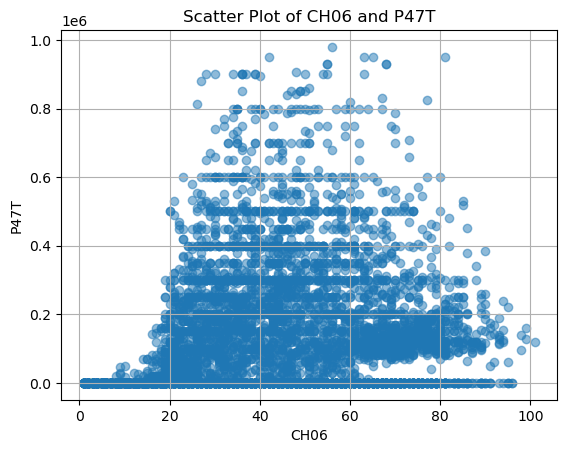

In [6]:
# 6. Relacion entre variables

#P47T y CH06

pr = df[df['P47T'] < 1000000]

plt.scatter(pr['CH06'], pr['P47T'], alpha=0.5)
plt.title("Scatter Plot of CH06 and P47T")
plt.ylabel("P47T")
plt.xlabel("CH06")
plt.grid(True)
plt.show()



In [7]:
# 7. Necesidades energeticas

bins = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 29, 45, 60, 75, float('inf')]
labels = [
    'less_than_1', '1_year', '2_year', '3_year', '4_year', '5_year', '6_year', '7_year', '8_year', '9_year', '10_year', 
    '11_year', '12_year', '13_year', '14_year', '15_year', '16_year', '17_year', '18_to_29', '30_to_45', 
    '46_to_60', '61_to_75', 'more_than_75'
]

df['age_group'] = pd.cut(df['CH06'], bins=bins, labels=labels)

#Dummie por genero y edad
for sex in [1, 2]:
    for label in labels:
        dummy_name = f'sex_{sex}_age_{label}'
        df[dummy_name] = ((df['CH04'] == sex) & (df['age_group'] == label)).astype(int)

energy_needs = {
    'less_than_1': {1: 0.35, 2: 0.35},
    '1_year': {1: 0.37, 2: 0.37},
    '2_year': {1: 0.46, 2: 0.46},
    '3_year': {1: 0.51, 2: 0.51},
    '4_year': {1: 0.55, 2: 0.55},
    '5_year': {1: 0.60, 2: 0.60},
    '6_year': {1: 0.64, 2: 0.64},
    '7_year': {1: 0.66, 2: 0.66},
    '8_year': {1: 0.68, 2: 0.68},
    '9_year': {1: 0.69, 2: 0.69},
    '10_year': {1: 0.79, 2: 0.70},
    '11_year': {1: 0.82, 2: 0.72},
    '12_year': {1: 0.85, 2: 0.74},
    '13_year': {1: 0.90, 2: 0.76},
    '14_year': {1: 0.96, 2: 0.76},
    '15_year': {1: 1.00, 2: 0.77},
    '16_year': {1: 1.03, 2: 0.77},
    '17_year': {1: 1.04, 2: 0.77},
    '18_to_29': {1: 1.02, 2: 0.76},
    '30_to_45': {1: 1.00, 2: 0.77},
    '46_to_60': {1: 1.00, 2: 0.76},
    '61_to_75': {1: 0.83, 2: 0.67},
    'more_than_75': {1: 0.74, 2: 0.63}
}

for sex in [1, 2]:
    for label in labels:
        dummy_name = f'sex_{sex}_age_{label}'
        energy_value = energy_needs[label][sex]
        df[dummy_name] = df[dummy_name] * energy_value

def get_positive_energy_value(row):
    for sex in [1, 2]:
        for label in labels:
            dummy_name = f'sex_{sex}_age_{label}'
            if row[dummy_name] > 0:
                return row[dummy_name]
    return 0

df['adulto_equiv'] = df.apply(get_positive_energy_value, axis=1)

df = df.loc[:, ~df.columns.str.startswith('sex_')]

df.drop(columns=['age_group'], inplace=True)

#Agrupamos por hogar CODUSU  ad equiv hogar
 
df['ad_equiv_hogar'] = df.groupby('CODUSU')['adulto_equiv'].transform('sum')

test = df[['CODUSU','CH04', 'CH06', 'adulto_equiv', 'ad_equiv_hogar' , 'ITF']]



In [8]:
# 8. Separar base y clasificar en pobre/no pobre

respondieron = df[df['ITF'] > 0].copy()

norespondieron = df[df['ITF'] <= 0].copy()

respondieron['ingreso_necesario'] = respondieron['ad_equiv_hogar'] * 132853.3

respondieron['pobre'] = np.where(respondieron['ingreso_necesario'] > respondieron['ITF'], 1, 0)

test = respondieron[['CODUSU','CH04', 'CH06', 'adulto_equiv', 'ad_equiv_hogar' ,'PONDIH', 'ITF', 'ingreso_necesario', 'pobre']]



In [9]:
# 9. PONDIH
test = norespondieron[['CODUSU','CH04', 'CH06', 'PONDIH', 'ITF']]

hogar = respondieron.drop_duplicates(subset=['CODUSU'])

total_hogares = hogar.shape[0]

hogares_pobres = hogar['pobre'].sum()

proporcion_hogares_pobres = hogares_pobres/total_hogares

print('Proporcion de hogares pobres:', proporcion_hogares_pobres)



Proporcion de hogares pobres: 0.29043478260869565


In [10]:
## Parte II ##

# 1. Funcion para evaluar metodo

def evaluar_metodo(modelo, X_train, X_test, y_train, y_test):
    
    modelo.fit(X_train, y_train)
    
    # Realizamos predicción sobre base test
    y_pred = modelo.predict(X_test)
    
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Matriz de Confusión:\n", conf_matrix)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    print("AUC del ROC:", roc_auc)  # AUC of ROC curve

    accuracy = accuracy_score(y_test, y_pred)
    print("Precisión (Accuracy):", accuracy)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC para KNN')
    plt.legend(loc="lower right")
    plt.show()

    
    accuracy = accuracy_score(y_test, y_pred)
    return {"confusion_matrix": conf_matrix, "accuracy": accuracy, "roc_auc": roc_auc}




In [11]:
# 2. Cross Validation

def cross_validation(modelo, k, X, y):
    kf = KFold(n_splits=k)
    resultados = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Escalar los datos
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        resultado_iteracion = evaluar_metodo(modelo, X_train_scaled, X_test_scaled, y_train, y_test)
        resultados.append(resultado_iteracion)
    
    return resultados


In [12]:
# 3. Evalua Config

def evalua_config(configuraciones, modelo_class, k, X, y):
    mejor_configuracion = None
    mejor_error = float('inf')
    
    for config in configuraciones:
        modelo = modelo_class(**config)
        resultados = cross_validation(modelo, k, X, y)
        
        # Calculate average error
        errores = [1 - resultado['accuracy'] for resultado in resultados]
        error_promedio = sum(errores) / len(errores)
        
        print(f"Configuración: {config}, Error promedio: {error_promedio}")
        
        if error_promedio < mejor_error:
            mejor_error = error_promedio
            mejor_configuracion = config
    
    return mejor_configuracion


In [13]:
# 4. Evaluar multiples metodo

def evalua_multiples_metodos(modelos_configs, k, X, y):
    resultados_totales = []
    
    for modelo_class, configuraciones in modelos_configs:
        mejor_config = evalua_config(configuraciones, modelo_class, k, X, y)
        modelo = modelo_class(**mejor_config)
        resultados = cross_validation(modelo, k, X, y)
        
        for resultado in resultados:
            resultado['modelo'] = modelo_class.__name__
            resultado['configuracion'] = mejor_config
            resultados_totales.append(resultado)
    
    # Convertir resultados a un DataFrame
    df_resultados = pd.DataFrame(resultados_totales)
    return df_resultados

In [15]:
## Parte III ##


# 1. Pre procesamientio de base 
cols_ingreso = ['CODUSU', 'ITF', 'IPCF', 'PP06C', 'PP06D', 'PP08D1',  'P21', 'TOT_P12', 
                'P47T', 'V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M',
                'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V21_M', 'T_VI', 
                'adulto_equiv', 'ad_equiv_hogar', 'CH05', 'PP09A_ESP',
                'DECINDR', 'ADECINDR', 'RDECINDR', 'PDECINDR', 'GDECINDR', 'IDECINDR',
                'DECOCUR','ADECOCUR','RDECOCUR','PDECOCUR','GDECOCUR','IDECOCUR',
                'DECIFR','ADECIFR','RDECIFR','PDECIFR','GDECIFR','IDECIFR','DECCFR',
                'ADECCFR','RDECCFR','PDECCFR','GDECCFR','IDECCFR'
                ]

df_res = respondieron.drop(columns = cols_ingreso + ['ingreso_necesario'], errors='ignore')
df_res = df_res.dropna(axis=1)
df_nores = norespondieron.drop(columns = cols_ingreso, errors = 'ignore')
df_nores = df_nores.dropna(axis=1)

X = df_res.drop(columns=['pobre'])  
X['intercept'] = 1 
y = df_res['pobre'] 




Matriz de Confusión:
 [[331  32]
 [ 86 163]]
AUC del ROC: 0.7832321019615653
Precisión (Accuracy): 0.8071895424836601


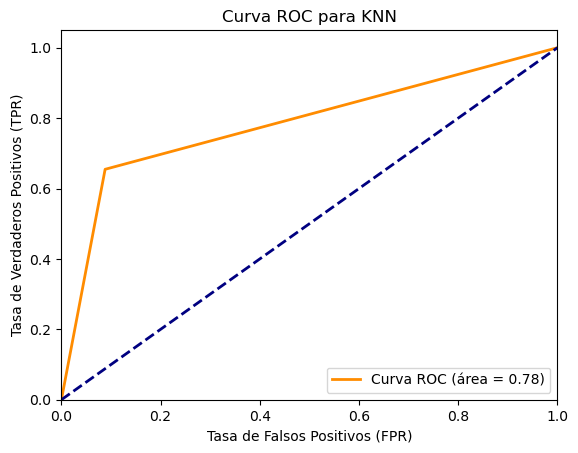

Matriz de Confusión:
 [[351  37]
 [ 78 145]]
AUC del ROC: 0.7774316952521843
Precisión (Accuracy): 0.8117839607201309


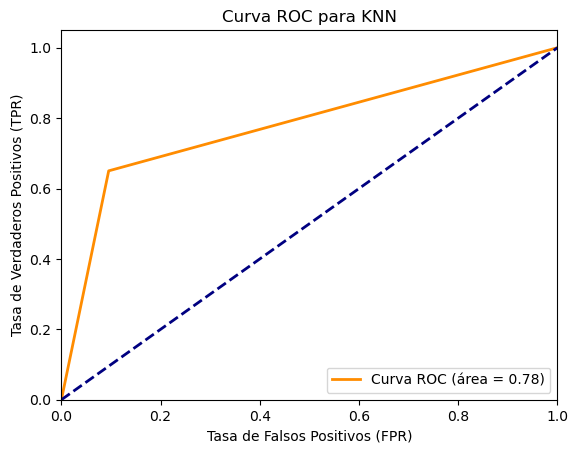

Matriz de Confusión:
 [[329  48]
 [ 72 162]]
AUC del ROC: 0.7824933687002653
Precisión (Accuracy): 0.8036006546644845


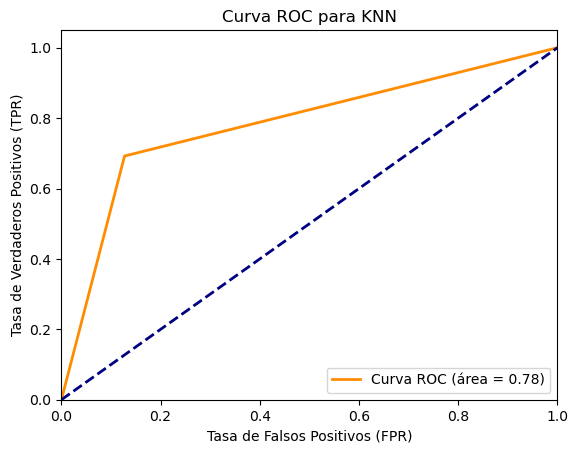

Matriz de Confusión:
 [[305  49]
 [ 87 170]]
AUC del ROC: 0.7615302600628723
Precisión (Accuracy): 0.7774140752864157


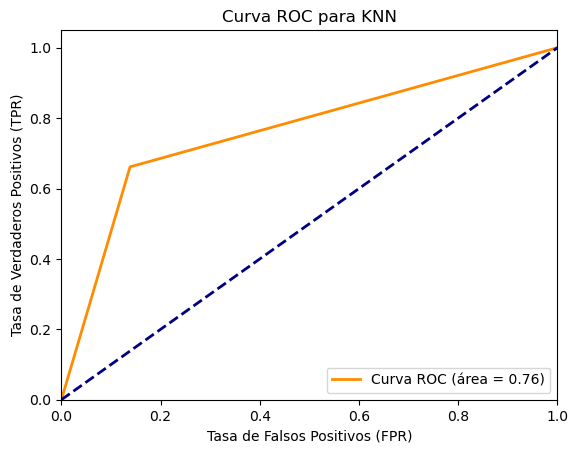

Matriz de Confusión:
 [[330  38]
 [ 91 152]]
AUC del ROC: 0.7611267668634818
Precisión (Accuracy): 0.7888707037643208


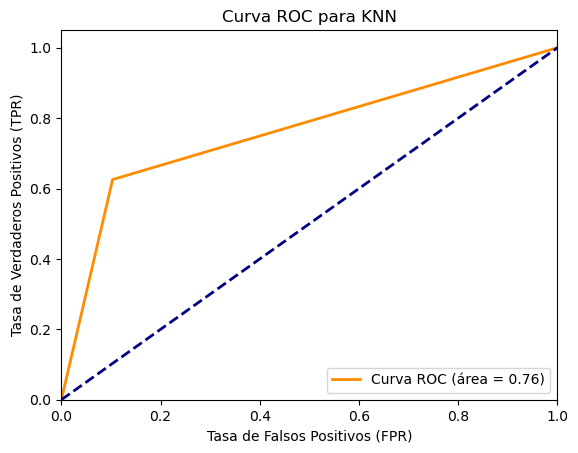

Configuración: {'C': 0.01}, Error promedio: 0.20222821261619756
Matriz de Confusión:
 [[325  38]
 [ 83 166]]
AUC del ROC: 0.78099173553719
Precisión (Accuracy): 0.8022875816993464


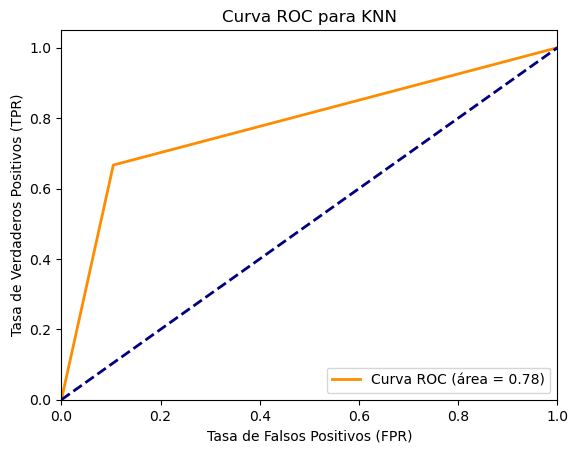

Matriz de Confusión:
 [[347  41]
 [ 71 152]]
AUC del ROC: 0.7879721233415007
Precisión (Accuracy): 0.8166939443535188


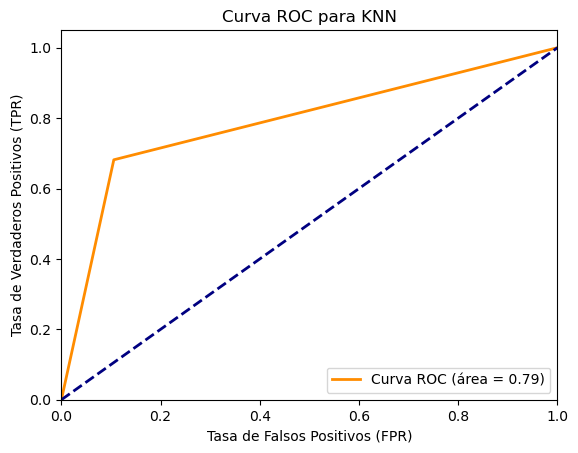

Matriz de Confusión:
 [[323  54]
 [ 70 164]]
AUC del ROC: 0.7788093132920719
Precisión (Accuracy): 0.7970540098199672


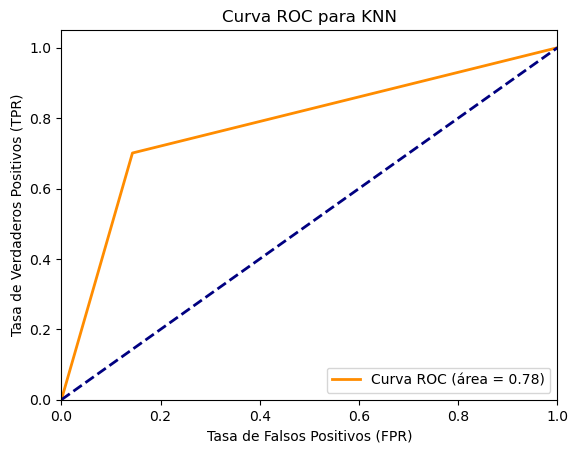

Matriz de Confusión:
 [[305  49]
 [ 86 171]]
AUC del ROC: 0.7634757853547011
Precisión (Accuracy): 0.779050736497545


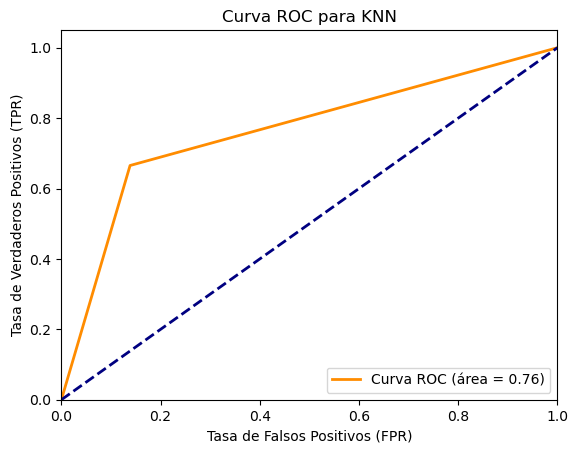

Matriz de Confusión:
 [[319  49]
 [ 81 162]]
AUC del ROC: 0.7667572463768115
Precisión (Accuracy): 0.7872340425531915


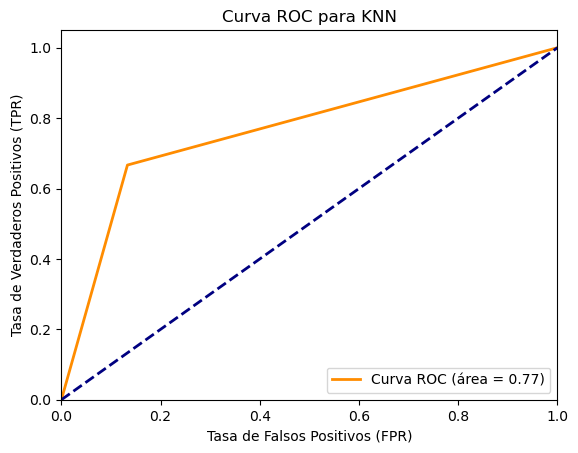

Configuración: {'C': 0.1}, Error promedio: 0.2035359370152862
Matriz de Confusión:
 [[316  47]
 [ 78 171]]
AUC del ROC: 0.7786352019648844
Precisión (Accuracy): 0.795751633986928


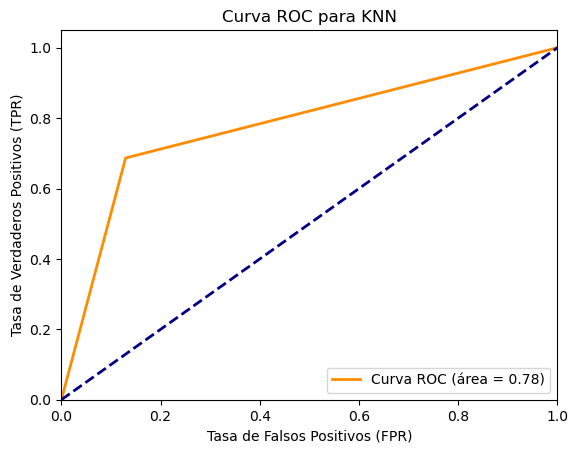

Matriz de Confusión:
 [[345  43]
 [ 70 153]]
AUC del ROC: 0.7876369562202393
Precisión (Accuracy): 0.8150572831423896


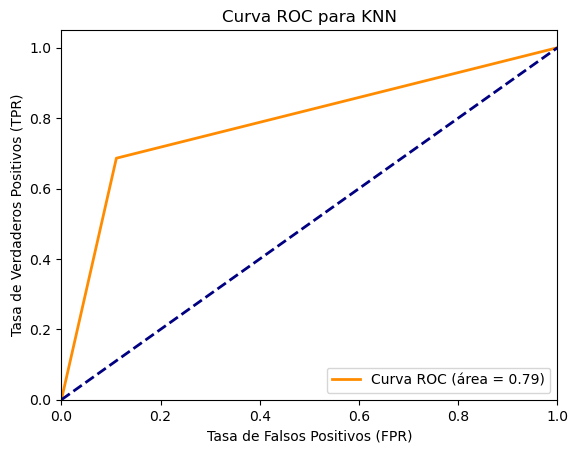

Matriz de Confusión:
 [[319  58]
 [ 72 162]]
AUC del ROC: 0.7692307692307693
Precisión (Accuracy): 0.7872340425531915


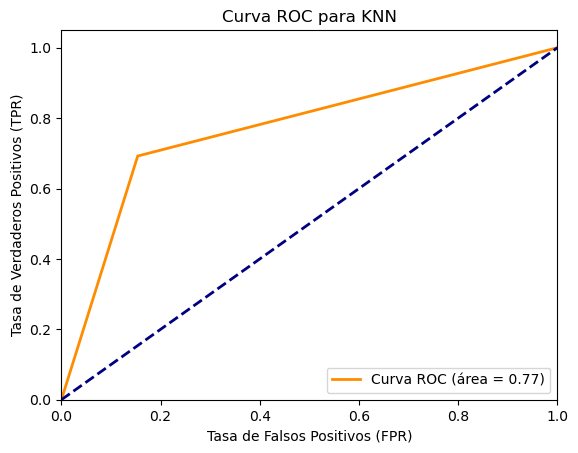

Matriz de Confusión:
 [[300  54]
 [ 90 167]]
AUC del ROC: 0.7486315372947305
Precisión (Accuracy): 0.7643207855973814


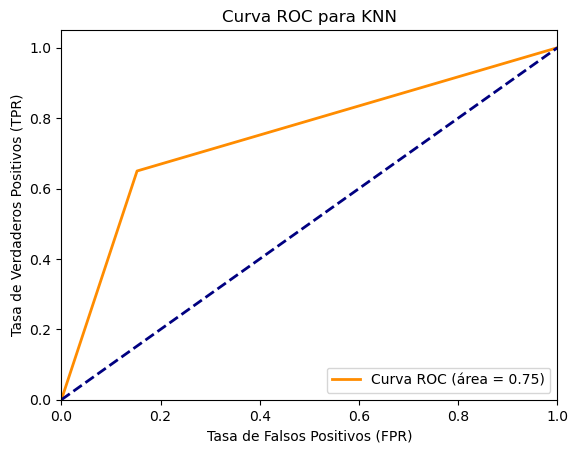

Matriz de Confusión:
 [[317  51]
 [ 77 166]]
AUC del ROC: 0.7722703077473609
Precisión (Accuracy): 0.79050736497545


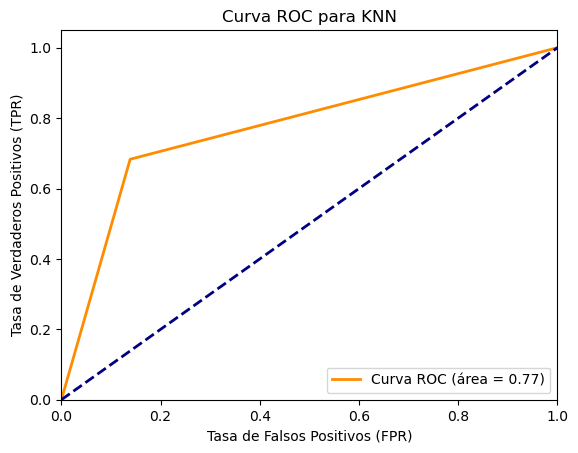

Configuración: {'C': 1}, Error promedio: 0.2094257779489319
Matriz de Confusión:
 [[316  47]
 [ 79 170]]
AUC del ROC: 0.7766271698363703
Precisión (Accuracy): 0.7941176470588235


C:\Users\tomas\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


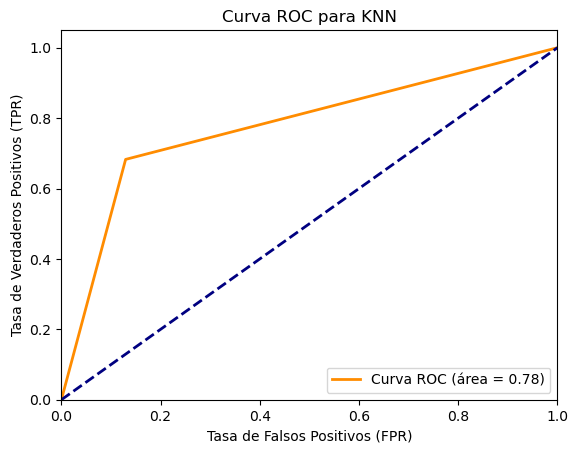

C:\Users\tomas\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matriz de Confusión:
 [[345  43]
 [ 70 153]]
AUC del ROC: 0.7876369562202393
Precisión (Accuracy): 0.8150572831423896


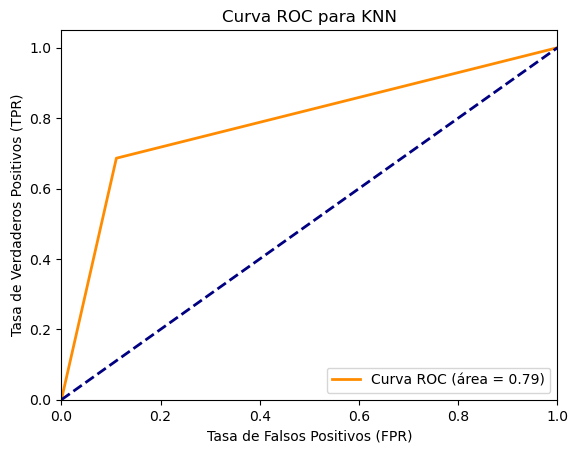

Matriz de Confusión:
 [[318  59]
 [ 72 162]]
AUC del ROC: 0.7679045092838195
Precisión (Accuracy): 0.7855973813420621


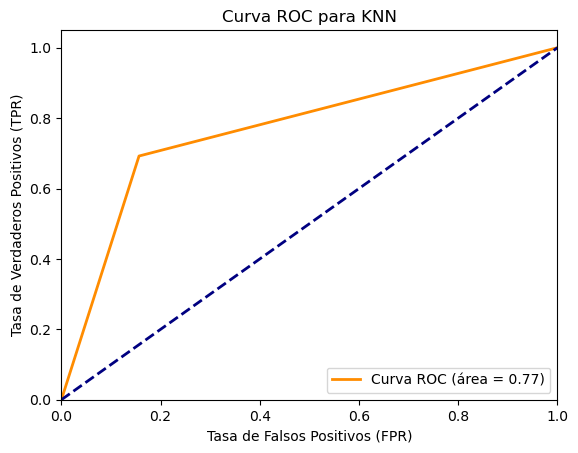

C:\Users\tomas\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matriz de Confusión:
 [[301  53]
 [ 89 168]]
AUC del ROC: 0.7519894919650904
Precisión (Accuracy): 0.7675941080196399


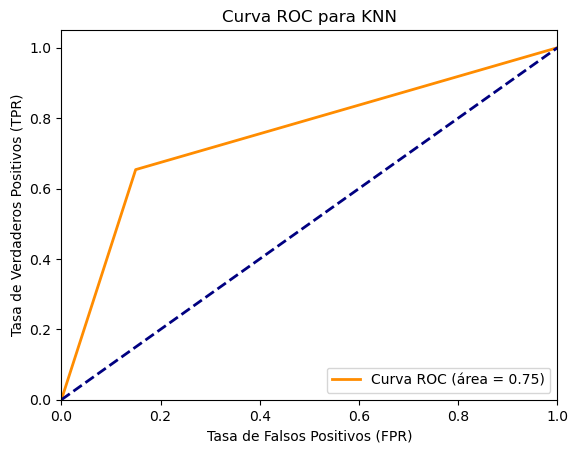

Matriz de Confusión:
 [[315  53]
 [ 77 166]]
AUC del ROC: 0.769552916443013
Precisión (Accuracy): 0.7872340425531915


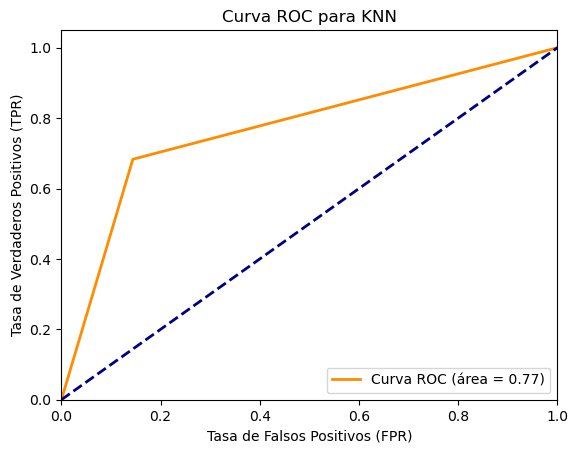

Configuración: {'C': 10}, Error promedio: 0.2100799075767787
Matriz de Confusión:
 [[316  47]
 [ 77 172]]
AUC del ROC: 0.7806432340933984
Precisión (Accuracy): 0.7973856209150327


C:\Users\tomas\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


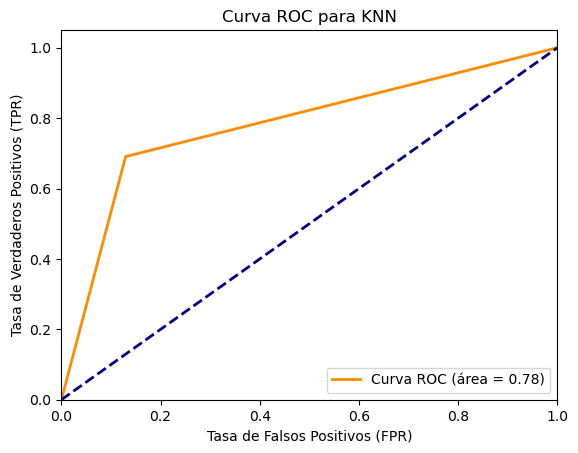

C:\Users\tomas\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matriz de Confusión:
 [[345  43]
 [ 70 153]]
AUC del ROC: 0.7876369562202393
Precisión (Accuracy): 0.8150572831423896


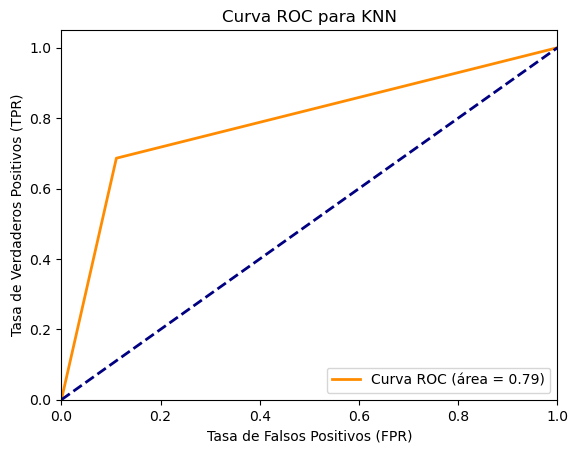

C:\Users\tomas\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matriz de Confusión:
 [[318  59]
 [ 71 163]]
AUC del ROC: 0.7700412614205717
Precisión (Accuracy): 0.7872340425531915


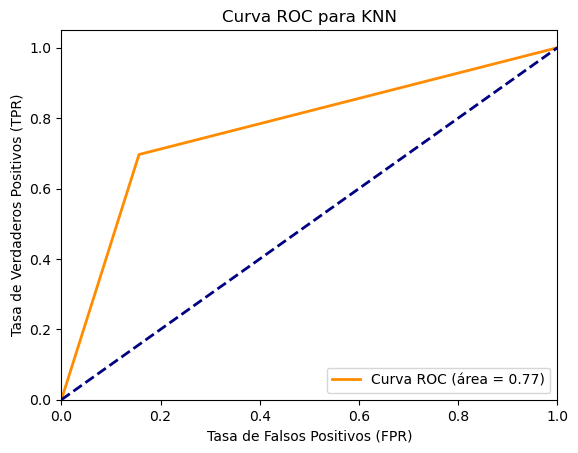

C:\Users\tomas\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matriz de Confusión:
 [[301  53]
 [ 88 169]]
AUC del ROC: 0.7539350172569191
Precisión (Accuracy): 0.7692307692307693


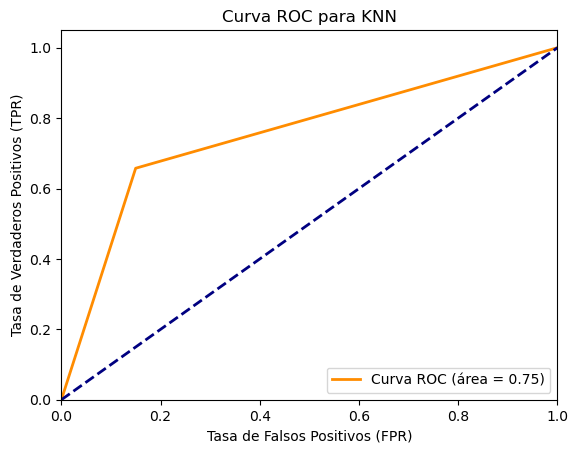

C:\Users\tomas\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matriz de Confusión:
 [[315  53]
 [ 77 166]]
AUC del ROC: 0.769552916443013
Precisión (Accuracy): 0.7872340425531915


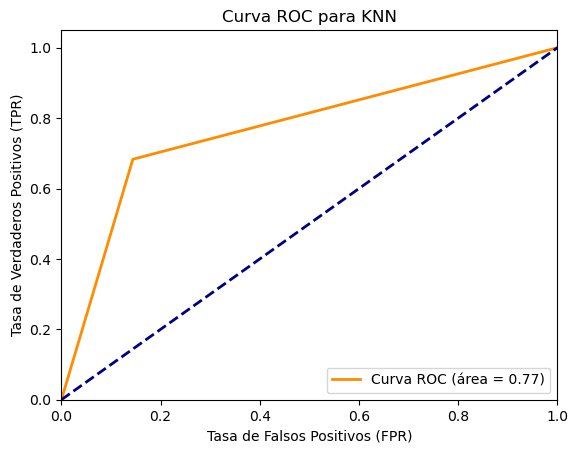

Configuración: {'C': 100}, Error promedio: 0.20877164832108508
Matriz de Confusión:
 [[331  32]
 [ 86 163]]
AUC del ROC: 0.7832321019615653
Precisión (Accuracy): 0.8071895424836601


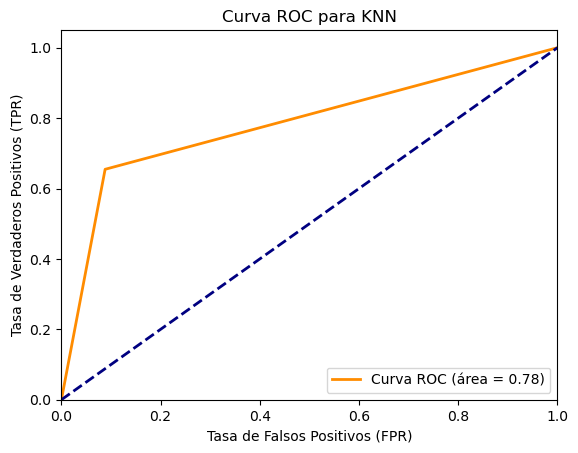

Matriz de Confusión:
 [[351  37]
 [ 78 145]]
AUC del ROC: 0.7774316952521843
Precisión (Accuracy): 0.8117839607201309


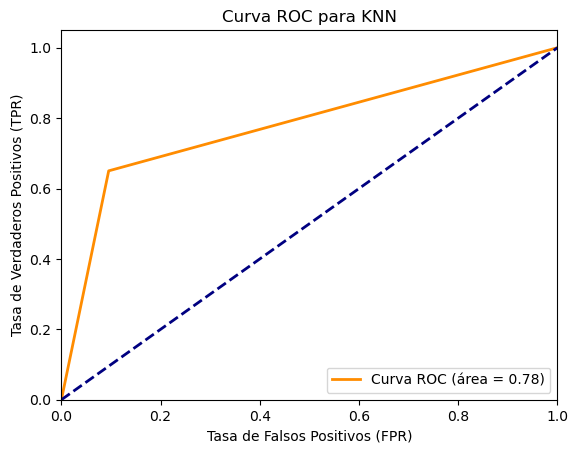

Matriz de Confusión:
 [[329  48]
 [ 72 162]]
AUC del ROC: 0.7824933687002653
Precisión (Accuracy): 0.8036006546644845


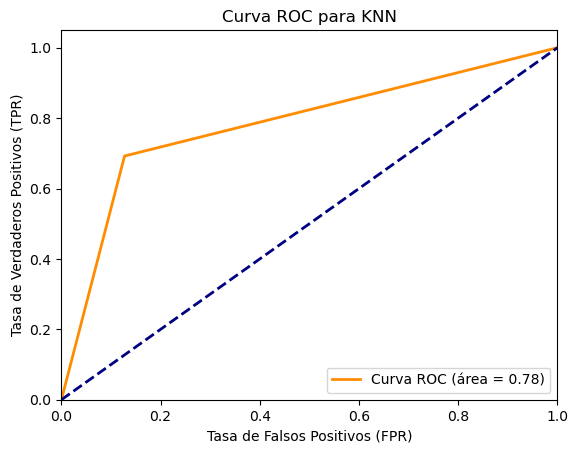

Matriz de Confusión:
 [[305  49]
 [ 87 170]]
AUC del ROC: 0.7615302600628723
Precisión (Accuracy): 0.7774140752864157


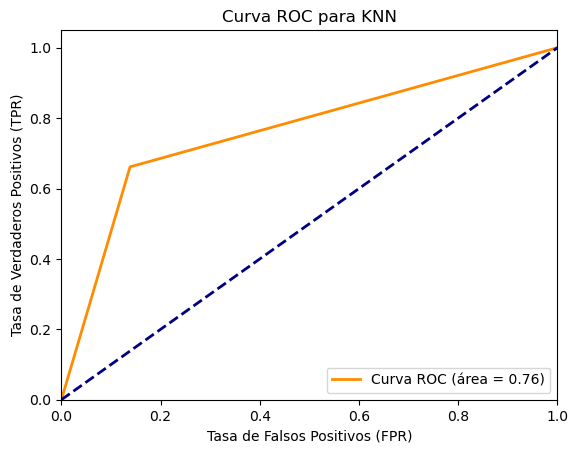

Matriz de Confusión:
 [[330  38]
 [ 91 152]]
AUC del ROC: 0.7611267668634818
Precisión (Accuracy): 0.7888707037643208


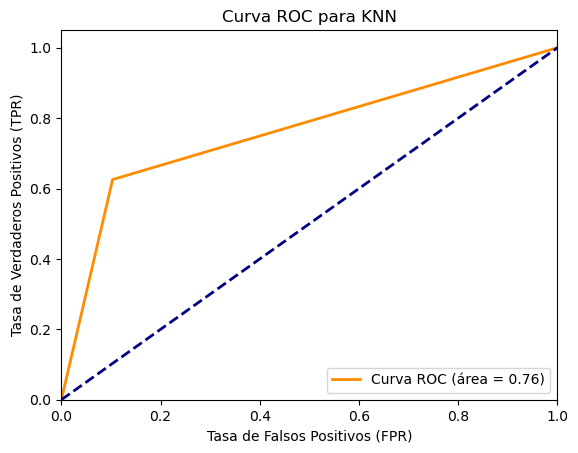

Matriz de Confusión:
 [[325  38]
 [ 90 159]]
AUC del ROC: 0.7669355106375917
Precisión (Accuracy): 0.7908496732026143


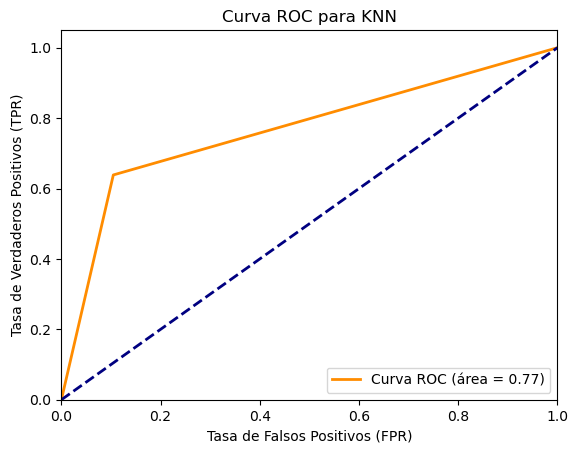

Matriz de Confusión:
 [[349  39]
 [ 76 147]]
AUC del ROC: 0.7793386805972908
Precisión (Accuracy): 0.8117839607201309


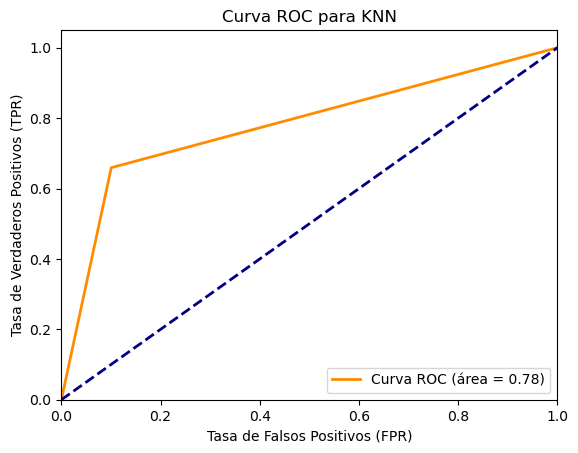

Matriz de Confusión:
 [[335  42]
 [ 73 161]]
AUC del ROC: 0.7883141762452107
Precisión (Accuracy): 0.8117839607201309


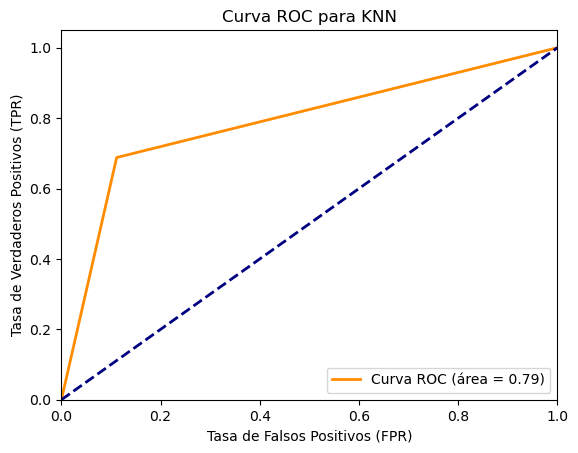

Matriz de Confusión:
 [[306  48]
 [ 98 159]]
AUC del ROC: 0.7415419112312868
Precisión (Accuracy): 0.7610474631751227


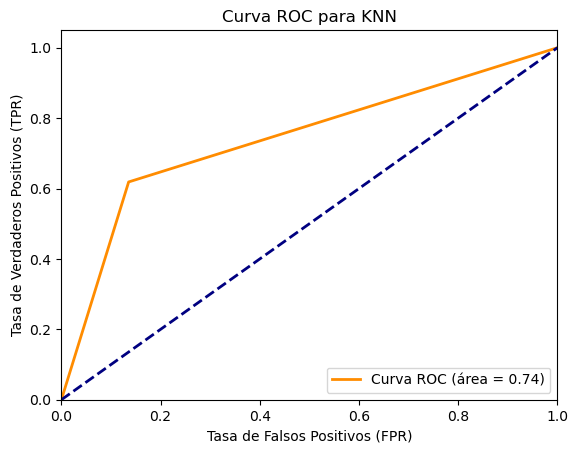

Matriz de Confusión:
 [[327  41]
 [ 86 157]]
AUC del ROC: 0.7673387457505815
Precisión (Accuracy): 0.7921440261865794


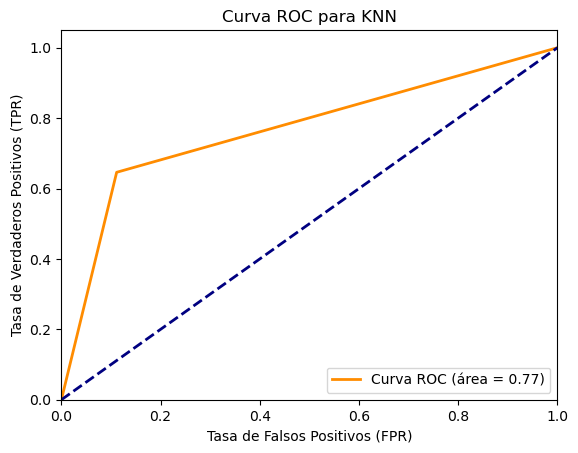

Configuración: {}, Error promedio: 0.20647818319908434
Matriz de Confusión:
 [[325  38]
 [ 90 159]]
AUC del ROC: 0.7669355106375917
Precisión (Accuracy): 0.7908496732026143


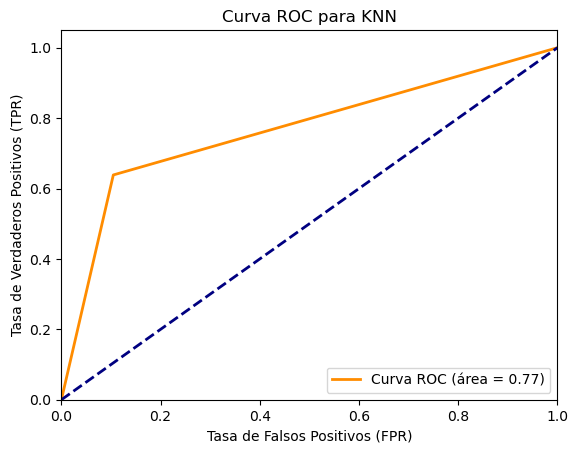

Matriz de Confusión:
 [[349  39]
 [ 76 147]]
AUC del ROC: 0.7793386805972908
Precisión (Accuracy): 0.8117839607201309


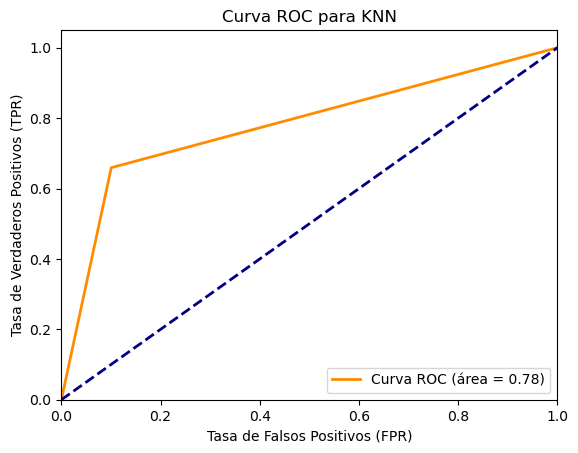

Matriz de Confusión:
 [[335  42]
 [ 73 161]]
AUC del ROC: 0.7883141762452107
Precisión (Accuracy): 0.8117839607201309


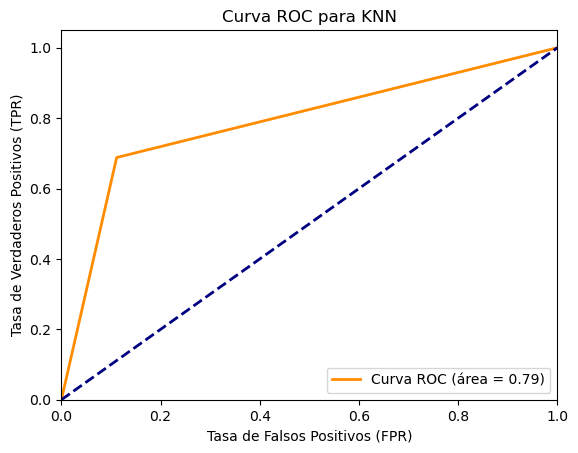

Matriz de Confusión:
 [[306  48]
 [ 98 159]]
AUC del ROC: 0.7415419112312868
Precisión (Accuracy): 0.7610474631751227


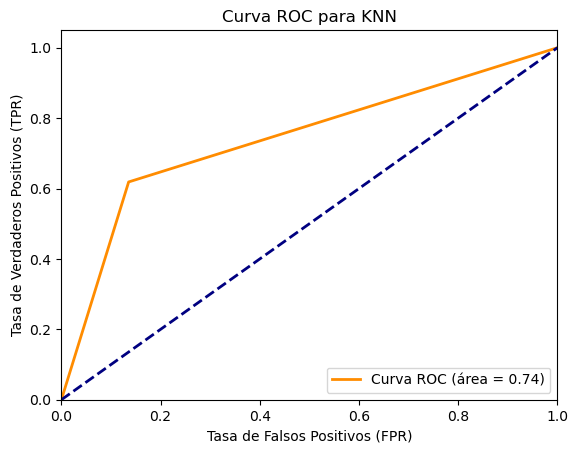

Matriz de Confusión:
 [[327  41]
 [ 86 157]]
AUC del ROC: 0.7673387457505815
Precisión (Accuracy): 0.7921440261865794


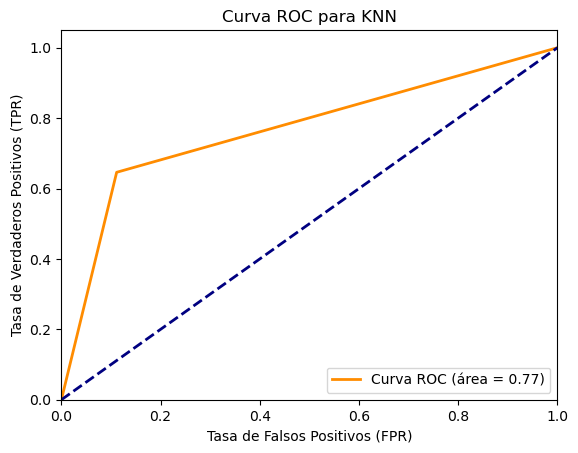

Matriz de Confusión:
 [[329  34]
 [ 92 157]]
AUC del ROC: 0.7684290882538417
Precisión (Accuracy): 0.7941176470588235


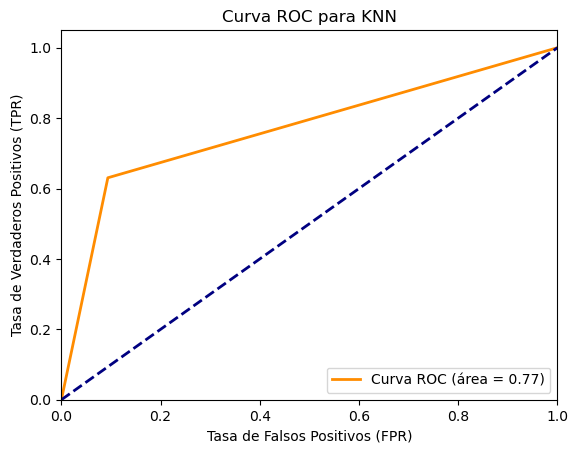

Matriz de Confusión:
 [[360  28]
 [ 81 142]]
AUC del ROC: 0.7823031759974112
Precisión (Accuracy): 0.8216039279869067


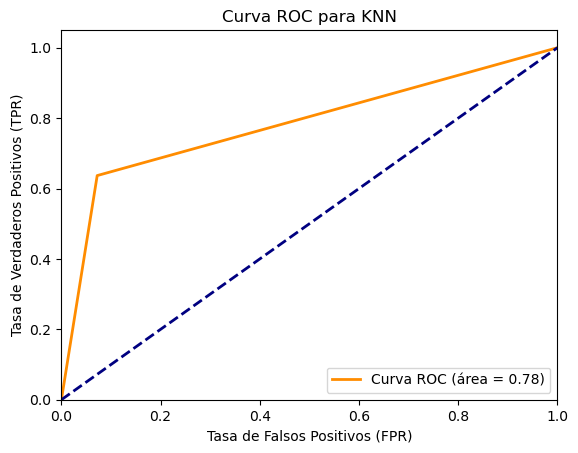

Matriz de Confusión:
 [[340  37]
 [ 68 166]]
AUC del ROC: 0.8056292366637196
Precisión (Accuracy): 0.8281505728314239


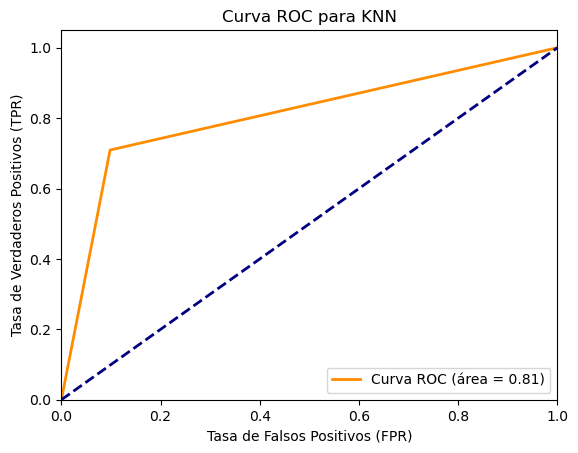

Matriz de Confusión:
 [[305  49]
 [ 84 173]]
AUC del ROC: 0.7673668359383587
Precisión (Accuracy): 0.7823240589198036


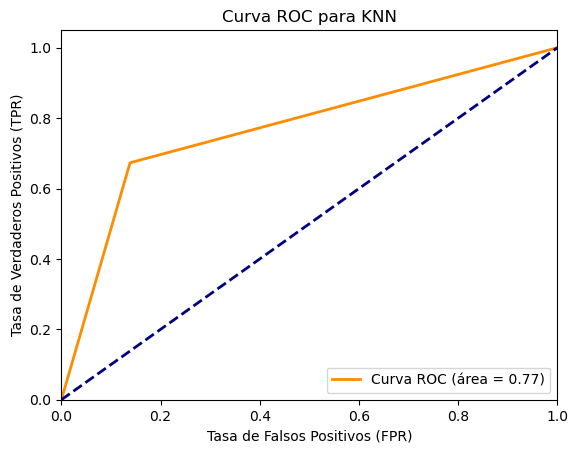

Matriz de Confusión:
 [[327  41]
 [ 78 165]]
AUC del ROC: 0.7837996511003757
Precisión (Accuracy): 0.8052373158756138


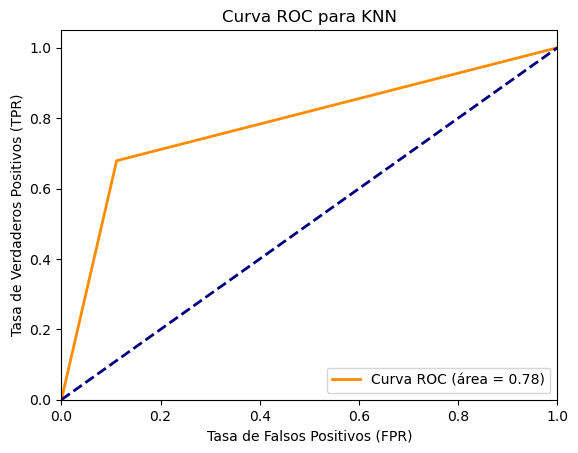

Configuración: {'n_neighbors': 3}, Error promedio: 0.1937132954654857
Matriz de Confusión:
 [[329  34]
 [ 92 157]]
AUC del ROC: 0.7684290882538417
Precisión (Accuracy): 0.7941176470588235


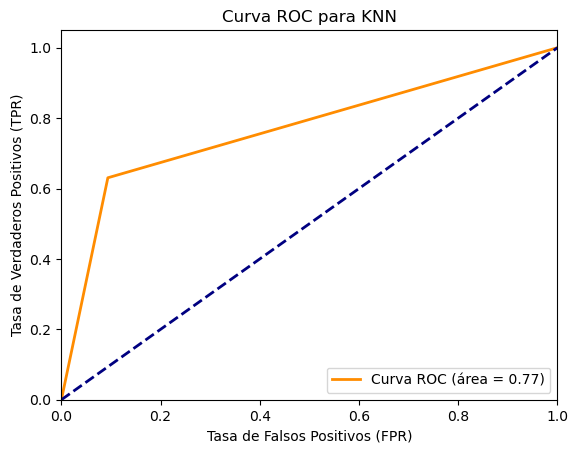

Matriz de Confusión:
 [[360  28]
 [ 81 142]]
AUC del ROC: 0.7823031759974112
Precisión (Accuracy): 0.8216039279869067


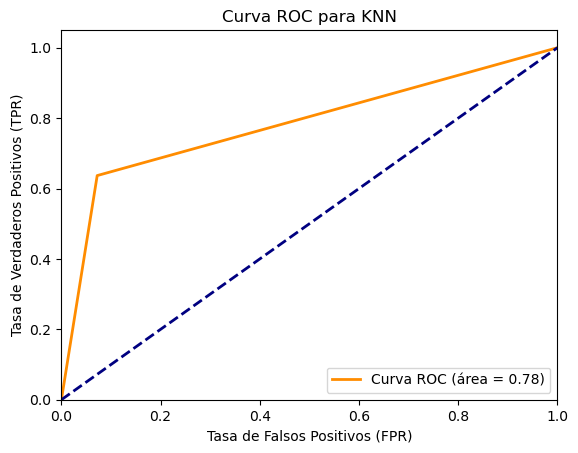

Matriz de Confusión:
 [[340  37]
 [ 68 166]]
AUC del ROC: 0.8056292366637196
Precisión (Accuracy): 0.8281505728314239


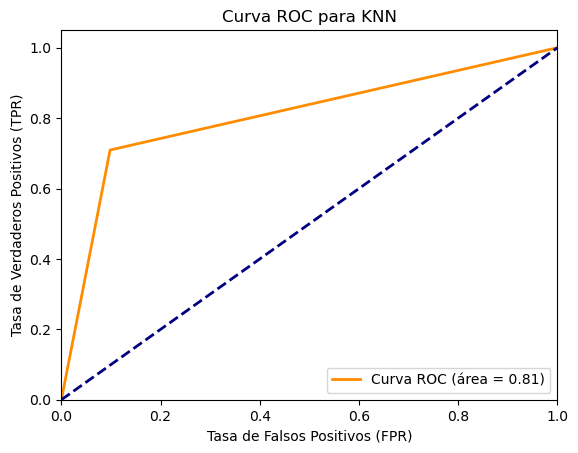

Matriz de Confusión:
 [[305  49]
 [ 84 173]]
AUC del ROC: 0.7673668359383587
Precisión (Accuracy): 0.7823240589198036


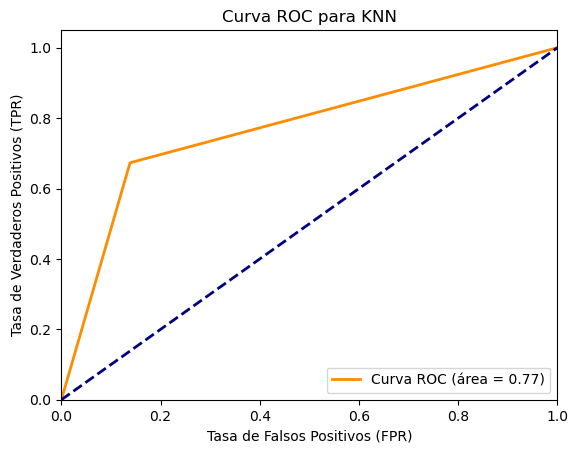

Matriz de Confusión:
 [[327  41]
 [ 78 165]]
AUC del ROC: 0.7837996511003757
Precisión (Accuracy): 0.8052373158756138


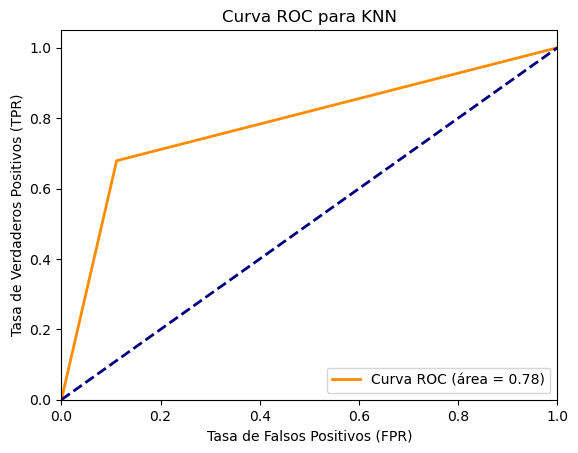

          confusion_matrix  accuracy   roc_auc                      modelo  \
0   [[331, 32], [86, 163]]  0.807190  0.783232          LogisticRegression   
1   [[351, 37], [78, 145]]  0.811784  0.777432          LogisticRegression   
2   [[329, 48], [72, 162]]  0.803601  0.782493          LogisticRegression   
3   [[305, 49], [87, 170]]  0.777414  0.761530          LogisticRegression   
4   [[330, 38], [91, 152]]  0.788871  0.761127          LogisticRegression   
5   [[325, 38], [90, 159]]  0.790850  0.766936  LinearDiscriminantAnalysis   
6   [[349, 39], [76, 147]]  0.811784  0.779339  LinearDiscriminantAnalysis   
7   [[335, 42], [73, 161]]  0.811784  0.788314  LinearDiscriminantAnalysis   
8   [[306, 48], [98, 159]]  0.761047  0.741542  LinearDiscriminantAnalysis   
9   [[327, 41], [86, 157]]  0.792144  0.767339  LinearDiscriminantAnalysis   
10  [[329, 34], [92, 157]]  0.794118  0.768429        KNeighborsClassifier   
11  [[360, 28], [81, 142]]  0.821604  0.782303        KNeighbors

In [16]:
# 2. Aplicar funcion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


modelos_configs = [
    (LogisticRegression, [{'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}]),
    (LinearDiscriminantAnalysis, [{}]),
    (KNeighborsClassifier, [{'n_neighbors': 3}])
]


# Evaluar múltiples métodos
resultados = evalua_multiples_metodos(modelos_configs, 5, X_train, y_train)
print(resultados)




In [ ]:
# 5. 

lambdas = [10**n for n in range(-5, 6)]
Cs = 1 / np.array(lambdas)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

ridge_errors = []
lasso_errors = []
lasso_zero_coefs = []


kf = KFold(n_splits=10, shuffle=True, random_state=101)


for C in Cs:
    ridge_model = LogisticRegression(C=C, penalty='l2', solver='liblinear', max_iter=10000)
    ridge_error = 1 - cross_val_score(ridge_model, X_train_scaled, y_train, cv=kf, scoring='accuracy')
    ridge_errors.append(ridge_error)
    
    lasso_model = LogisticRegression(C=C, penalty='l1', solver='liblinear', max_iter=10000)
    lasso_error = 1 - cross_val_score(lasso_model, X_train_scaled, y_train, cv=kf, scoring='accuracy')
    lasso_errors.append(lasso_error)
    
    # Para LASSO, calcular proporción de coeficientes cero
    zero_coefs = []
    for train_index, test_index in kf.split(X_train_scaled):
        X_kf_train, X_kf_test = X_train_scaled[train_index], X_train_scaled[test_index]
        y_kf_train, y_kf_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        lasso_model.fit(X_kf_train, y_kf_train)
        zero_coef_proportion = np.mean(lasso_model.coef_ == 0)
        zero_coefs.append(zero_coef_proportion)
    
    lasso_zero_coefs.append(zero_coefs)

ridge_df = pd.DataFrame(ridge_errors, index=lambdas).T
lasso_df = pd.DataFrame(lasso_errors, index=lambdas).T
lasso_zero_coefs_df = pd.DataFrame(lasso_zero_coefs, index=lambdas).T




In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
ridge_df.boxplot()
plt.title('Distribución del error de predicción para Ridge')
plt.xlabel('Lambda')
plt.ylabel('Error de predicción')

plt.subplot(1, 2, 2)
lasso_df.boxplot()
plt.title('Distribución del error de predicción para LASSO')
plt.xlabel('Lambda')
plt.ylabel('Error de predicción')

plt.tight_layout()
plt.show()

# Box-plot de la proporción de variables ignoradas para LASSO
plt.figure(figsize=(7, 6))
lasso_zero_coefs_df.boxplot()
plt.title('Proporción de variables ignoradas para LASSO')
plt.xlabel('Lambda')
plt.ylabel('Proporción de coeficientes cero')
plt.show()

In [ ]:
# 6. Variables descartadas

optimal_lambda = 10**1
optimal_C = 1 / optimal_lambda

# Entrenar el modelo LASSO con el valor óptimo de lambda
lasso_model_optimal = LogisticRegression(C=optimal_C, penalty='l1', solver='liblinear', max_iter=10000)
lasso_model_optimal.fit(X_train_scaled, y_train)

# Obtener los coeficientes del modelo
coeficientes = lasso_model_optimal.coef_[0]

# Identificar las variables descartadas (coeficientes cero)
variables_descartadas = X_train.columns[coeficientes == 0]
variables_no_descartadas = X_train.columns[coeficientes != 0]

print("Variables descartadas (coeficientes cero):")
print(variables_descartadas)

In [ ]:
# 7. LASSO vs Ridge

optimal_lambda_ridge = 10**1 
optimal_lambda_lasso = 10**1  

optimal_C_ridge = 1 / optimal_lambda_ridge
optimal_C_lasso = 1 / optimal_lambda_lasso

# Entrenar y predecir con el modelo Ridge
ridge_model_optimal = LogisticRegression(C=optimal_C_ridge, penalty='l2', solver='liblinear', max_iter=10000)
y_pred_ridge = cross_val_predict(ridge_model_optimal, X_train_scaled, y_train, cv=10)

# Calcular el ECM para Ridge
ecm_ridge = mean_squared_error(y_train, y_pred_ridge)

# Entrenar y predecir con el modelo LASSO
lasso_model_optimal = LogisticRegression(C=optimal_C_lasso, penalty='l1', solver='liblinear', max_iter=10000)
y_pred_lasso = cross_val_predict(lasso_model_optimal, X_train_scaled, y_train, cv=10)

# Calcular el ECM para LASSO
ecm_lasso = mean_squared_error(y_train, y_pred_lasso)

print("Error cuadrático medio (ECM) para Ridge: {:.4f}".format(ecm_ridge))
print("Error cuadrático medio (ECM) para LASSO: {:.4f}".format(ecm_lasso))